In [1]:
%matplotlib inline

import sys

import caffe
import theano
import theano.tensor as T
import numpy as np
import matplotlib.pyplot as plt
from theano.tensor.signal.pool import pool_2d
from scipy.misc import imread, imsave
from scipy.optimize import fmin_l_bfgs_b
from tqdm import tqdm

Using gpu device 1: Tesla K80 (CNMeM is disabled, cuDNN 5005)


In [2]:
def vgg_conv_layer(input_, vgg_caffe, layer):
    W_weights = vgg_caffe.params[layer][0].data
    b_weights = vgg_caffe.params[layer][1].data
    W = theano.shared(W_weights, borrow=True)
    b = theano.shared(b_weights, borrow=True)
    return T.nnet.relu(T.nnet.conv2d(input_, W, border_mode="half") + b.dimshuffle("x", 0, "x", "x"))

def load_img(filename):
    img = imread(filename).transpose((2, 0, 1))[::-1].astype(theano.config.floatX)
    img[0, :, :] -= 103.939
    img[1, :, :] -= 116.779
    img[2, :, :] -= 123.68
    return img[np.newaxis, :]

def orig(img):
    img = np.copy(img)[0, :, :, :]
    img[0, :, :] += 103.939
    img[1, :, :] += 116.779
    img[2, :, :] += 123.68
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img[::-1].transpose((1, 2, 0))
    
def show_img(img):
    plt.imshow(orig(img))
    plt.axis("off")

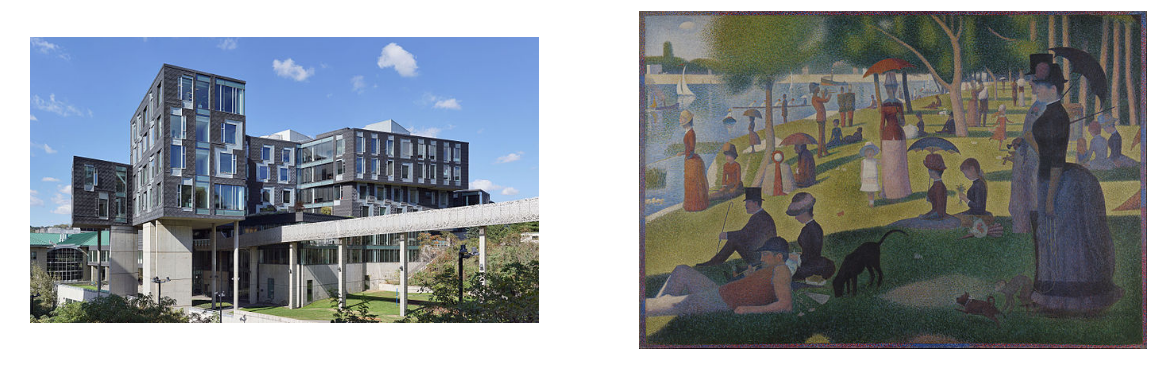

In [3]:
content_image = load_img("data/images/original/photos/ghc.jpg")
style_image = load_img("data/images/original/paintings/la_grande_jatte.jpg")
plt.figure(figsize=(20, 7))
plt.subplot(1, 2, 1)
show_img(content_image)
plt.subplot(1, 2, 2)
show_img(style_image)

In [4]:
vgg_caffe = caffe.Net("data/vgg19/vgg19.prototxt", "data/vgg19/vgg19_normalized.caffemodel", caffe.TEST)

X = theano.shared(np.array([[[[]]]], dtype=theano.config.floatX), borrow=True)
conv1_1 = vgg_conv_layer(X, vgg_caffe, "conv1_1")
conv1_2 = vgg_conv_layer(conv1_1, vgg_caffe, "conv1_2")
pool1 = pool_2d(conv1_2, (2, 2), ignore_border=True, mode="average_exc_pad")

conv2_1 = vgg_conv_layer(pool1, vgg_caffe, "conv2_1")
conv2_2 = vgg_conv_layer(conv2_1, vgg_caffe, "conv2_2")
pool2 = pool_2d(conv2_2, (2, 2), ignore_border=True, mode="average_exc_pad")

conv3_1 = vgg_conv_layer(pool2, vgg_caffe, "conv3_1")
conv3_2 = vgg_conv_layer(conv3_1, vgg_caffe, "conv3_2")
conv3_3 = vgg_conv_layer(conv3_2, vgg_caffe, "conv3_3")
conv3_4 = vgg_conv_layer(conv3_3, vgg_caffe, "conv3_4")
pool3 = pool_2d(conv3_4, (2, 2), ignore_border=True, mode="average_exc_pad")

conv4_1 = vgg_conv_layer(pool3, vgg_caffe, "conv4_1")
conv4_2 = vgg_conv_layer(conv4_1, vgg_caffe, "conv4_2")
conv4_3 = vgg_conv_layer(conv4_2, vgg_caffe, "conv4_3")
conv4_4 = vgg_conv_layer(conv4_3, vgg_caffe, "conv4_4")
pool4 = pool_2d(conv4_4, (2, 2), ignore_border=True, mode="average_exc_pad")

conv5_1 = vgg_conv_layer(pool4, vgg_caffe, "conv5_1")
conv5_2 = vgg_conv_layer(conv5_1, vgg_caffe, "conv5_2")
conv5_3 = vgg_conv_layer(conv5_2, vgg_caffe, "conv5_3")
conv5_4 = vgg_conv_layer(conv5_3, vgg_caffe, "conv5_4")

In [5]:
X.set_value(content_image, borrow=True)
target = conv4_2
get_target = theano.function([], target)
content_target = theano.shared(get_target(), borrow=True)
content_loss = T.sum(T.sqr(target - content_target))

In [6]:
X.set_value(style_image, borrow=True)
style_loss = 0
for target in [conv1_1, conv2_1, conv3_1, conv4_1, conv5_1]:
    target_flat = T.reshape(target, (target.shape[1], -1))
    gram_target = T.dot(target_flat, target_flat.T)
    get_gram_target = theano.function([], gram_target)
    style_gram_target = theano.shared(get_gram_target(), borrow=True)
    gram_loss_normalizer = T.cast(T.square(target.shape[1] * target.shape[2] * target.shape[3]), theano.config.floatX)
    style_loss = style_loss + T.sum(T.sqr(gram_target - style_gram_target)) / gram_loss_normalizer

In [7]:
content_weight = 0.001
style_weight = 0.4e6
loss = content_weight * content_loss + style_weight * style_loss
loss_function_theano = theano.function([], loss)

def loss_function(X_flat):
    X.set_value(X_flat.reshape(content_image.shape).astype(theano.config.floatX))
    return loss_function_theano().astype(np.float64)

grad = T.grad(loss, X)
grad_function_theano = theano.function([], grad)

def grad_function(X_flat):
    X.set_value(X_flat.reshape(content_image.shape).astype(theano.config.floatX))
    return np.array(grad_function_theano()).flatten().astype(np.float64)

Generating image: 501it [04:25,  1.99it/s]                                      


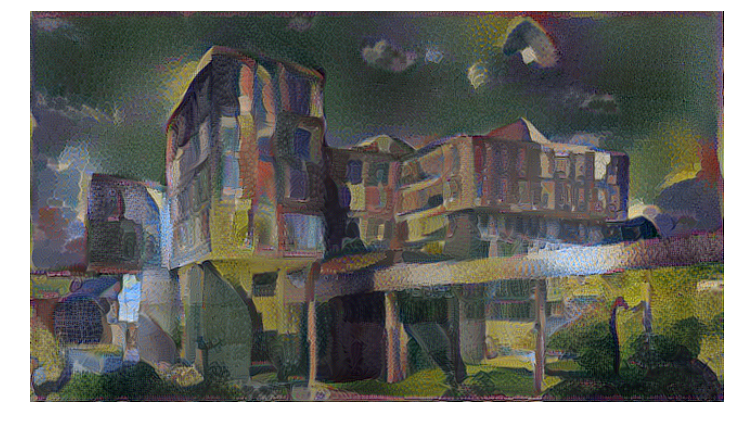

In [8]:
output_image_flat = np.random.normal(size=content_image.shape, scale=10).flatten()
iterations = 500
with tqdm(desc="Generating image", total=iterations, file=sys.stdout, ncols=80, ascii=False, bar_format="{l_bar}{bar}|") as pbar:
    output_image_flat = fmin_l_bfgs_b(loss_function, output_image_flat, grad_function, maxiter=iterations, callback=lambda xk: pbar.update(1))[0]
output_image = output_image_flat.reshape(content_image.shape)
plt.figure(figsize=(15, 7))
show_img(output_image)

In [9]:
imsave("data/images/generated/ghc/ghc_la_grande_jatte.jpg", orig(output_image))